# Conditional Variational Autoencoder with JAX 
Trained with MNIST images

## How the CVAE learns the connection between images and labels:
1. Conditional Encoding and Latent Space Structuring

    In the encoder, both the image $x$ and label $c$ (converted to a one-hot encoded vector) are concatenated and passed through the network to learn a latent representation $z$. By including $c$, the encoder learns to structure the latent space based on this additional label information, enabling it to differentiate representations by class or label.

    The encoder learns to map $(x,c)$ to a latent distribution $q(z|x,c)$, capturing data variations within each class separately.

    This structuring means that, for example, latent representations for images of a digit "3" will be more clustered in one part of the space, while "7" might be in another, with the label $c$ guiding this separation.

2. Conditional Decoding

   During decoding, the CVAE uses both the latent variable $z$ and the label $c$ to reconstruct the input as $p(x|z,c)$. This conditioning ensures that generated samples are aligned with the given label $c$, allowing the model to output images that resemble the conditioned label. Essentially, it gives control over the generation process, making it possible to generate specific types of data (e.g., MNIST digits corresponding to "3" or "7").

# Import libraries

In [48]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
import os
import numpy as np
import pickle

# Building the model

## Onehot function

In [49]:
def onehot(x, max_dim):
    """Convert labels to one-hot encoding."""
    batch_size = x.shape[0]
    vector = jnp.zeros((batch_size, max_dim))
    one_hot = vector.at[jnp.arange(batch_size), x].set(1)
    return one_hot

## Build encoder 

In [50]:
class Encoder(nn.Module):
    hidden_size: int
    latent_size: int

    def setup(self):
        self.linear = nn.Dense(self.hidden_size)
        self.mu = nn.Dense(self.latent_size)
        self.sigma = nn.Dense(self.latent_size)
        
        # # Convolutional layers
        # self.conv1 = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2))  # output: 14x14x32
        # self.conv2 = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2))  # output: 7x7x64

        # # Fully connected layers
        # self.fc = nn.Dense(self.hidden_size)
        # self.mu = nn.Dense(self.latent_size)
        # self.sigma = nn.Dense(self.latent_size)

    # def __call__(self, x):
    #     x = nn.relu(self.conv1(x))
    #     x = nn.relu(self.conv2(x))
    #     x = jnp.reshape(x, (x.shape[0], -1))  # Flatten the 2D feature maps manually
    #     x = nn.relu(self.fc(x))
    #     mu = self.mu(x)
    #     sigma = self.sigma(x)
    #     return mu, sigma
        
    def __call__(self, x):
        # print("Input to Encoder:", x.shape)  # Print input shape
        x = nn.relu(self.linear(x))
        # print("After Linear Layer:", x.shape)  # Print shape after linear layer
        mu = self.mu(x)
        # print("Mu Shape:", mu.shape)  # Print mu shape
        sigma = self.sigma(x)
        # print("Sigma Shape:", sigma.shape)  # Print sigma shape
        return mu, sigma
 

## Build decoder

In [51]:
class Decoder(nn.Module):
    hidden_size: int
    output_size: int

    def setup(self):
        self.linear1 = nn.Dense(self.hidden_size)
        self.linear2 = nn.Dense(self.output_size)

        # # Fully connected layers to expand from latent space to feature map
        # self.fc = nn.Dense(self.hidden_size)
        # self.fc_reshape = nn.Dense(7 * 7 * 64)
        
        # # Transpose Convolutional layers
        # self.fc_reshape = nn.Dense(7 * 7 * 64)
        # self.convT1 = nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')  # upsample to 14x14
        # self.convT2 = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')  # upsample to 28x28
        # self.convT3 = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(1, 1), padding='SAME')  # final output


    # def __call__(self, x):
        # x = nn.relu(self.fc(x))
        # x = nn.relu(self.fc_reshape(x))
        # x = jnp.reshape(x, (-1, 7, 7, 64))  # Reshape to a 2D feature map for transposed convolutions
        # x = nn.relu(self.convT1(x))
        # x = nn.relu(self.convT2(x))
        # x = nn.sigmoid(self.convT3(x)).reshape((-1, 28 * 28))  # Flatten for binary cross-entropy
        # return x
        
    def __call__(self, x):
        # print("Input to Decoder:", x.shape)  # Print input shape
        x = nn.relu(self.linear1(x))
        # print("After First Linear Layer:", x.shape)  # Print shape after first linear layer
        x = nn.sigmoid(self.linear2(x))
        # print("Output Shape:", x.shape)  # Print output shape
        return x


## Combine encoder and decoder

In [52]:
class CVAE(nn.Module):
    input_size: int
    output_size: int
    condition_size: int
    latent_size: int
    hidden_size: int

    def setup(self):
        self.encoder = Encoder(hidden_size=self.hidden_size, latent_size=self.latent_size)
        self.decoder = Decoder(hidden_size=self.hidden_size, output_size=self.output_size)

    def __call__(self, x, c):
        # print("Shape of x:", x.shape)
        # print("Shape of c:", c.shape)
        x = jnp.concatenate((x, c), axis=1) # Concatenate the input x and condition c
        # print("Shape after concatenating x and c:", x.shape)  # Print input shape to CVAE
        mu, sigma = self.encoder(x)
        # print("Mu Shape:", mu.shape)  # Print shape of mu
        # print("Sigma Shape:", sigma.shape)  # Print shape of sigma

        # Sample from standard normal distribution
        eps = jax.random.normal(jax.random.PRNGKey(0), sigma.shape)
        z = mu + eps * jnp.exp(0.5 * sigma)
        z_cond = jnp.concatenate((z, c), axis=1)
        # print("Input to Decoder:", z.shape)  # Print input shape to decoder

        recon_x = self.decoder(z_cond)
        return recon_x, mu, sigma

    def decode(self, z, c):
        """Decode from latent space given a condition."""
        z = jnp.concatenate((z, c), axis=1)  # Concatenate latent vector and condition
        return self.decoder(z)  # Use decoder to reconstruct the image


## Define loss function

The CVAE’s loss function has the same terms as the VAE, combining the **reconstruction loss** (likelihood of data given latent and condition) and the **KL divergence** (difference between learned and prior distributions). However, both terms now incorporate the condition $c$ as a context, which refines how the loss shapes the latent space.

In [53]:
def loss_fn(recon_x, x, mu, sigma):
    """Compute the loss for the CVAE."""
    loss_re = optax.sigmoid_binary_cross_entropy(recon_x, x).sum()
    loss_norm = -0.5 * jnp.sum(1 + sigma - jnp.square(mu) - jnp.exp(sigma))
    return loss_re + loss_norm


# Hyperparameters and model construction

## Model parameters

In [54]:
latent_size = 16  # latent space dimension
hidden_size = 128  # hidden layer dimension
input_size = output_size = 28 * 28 
condition_size = 10 

## Training parameters

In [55]:
epochs = 10
batch_size = 32 
learning_rate = 3e-3

## Model construction

In [56]:
# Initialize model and optimizer
model = CVAE(input_size, output_size, condition_size, latent_size, hidden_size)
# Update the input shape to include the condition size
input_shape = (batch_size, input_size)  # Correct shape
params = model.init(jax.random.PRNGKey(0), jnp.ones(input_shape), jnp.ones((batch_size, condition_size)))
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Load dataset and visualise

In [57]:
# Load the dataset using PyTorch
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [58]:
for batch in train_loader:
    # Convert the list to a tensor
    data_tensor = torch.tensor(batch[0])
    print(data_tensor.shape)
    break

torch.Size([32, 1, 28, 28])


/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_39193/679139505.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(batch[0])


In [59]:
# Check the length of the dataset
print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")
print(train_dataset[60][1])

Number of samples in training set: 60000
Number of samples in test dataset: 10000
4


Image shape: torch.Size([1, 28, 28])
Image data type: torch.float32
Label: 4


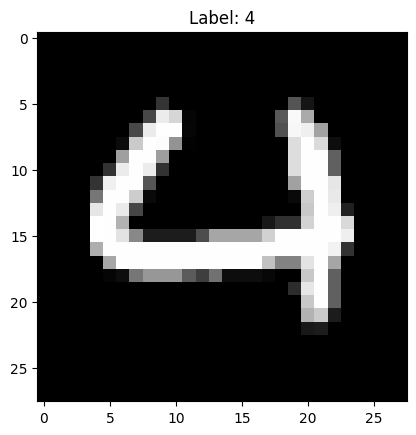

In [60]:
def inspect_train_set(train_dataset):
    '''Function to inspect the train_set'''

    # Get the first sample (image, label)
    sample_image, sample_label = train_dataset[60]

    # Check the shape and type of the image
    print(f"Image shape: {sample_image.shape}")
    print(f"Image data type: {sample_image.dtype}")
    print(f"Label: {sample_label}")

    # Visualize the first image
    plt.imshow(sample_image.squeeze(), cmap='gray')
    plt.title(f"Label: {sample_label}")
    plt.show()

# Inspect the train_set
inspect_train_set(train_dataset)

In [61]:
# for imgs, lbls in tqdm(train_loader):
#     # Flatten images to shape (batch_size, 784)
#     imgs = imgs.view(imgs.shape[0], -1)  
#     print("Shape of imgs:", imgs.shape)  # Should be (batch_size, 784)
    
#     # One-hot encode the labels
#     lbls = onehot(lbls.numpy(), condition_size)  # Convert to one-hot encoding
#     print("Shape of lbls:", lbls.shape)  # Should be (batch_size, 10)

#     # Convert to JAX arrays
#     imgs = jnp.array(imgs.numpy())  # Shape (batch_size, 784)
#     lbls = jnp.array(lbls)  # Shape (batch_size, 10)

#     # Concatenate images and labels for encoder input
#     inputs = jnp.concatenate((imgs, lbls), axis=1)  # Shape (batch_size, 794)
#     print("Shape of inputs:", inputs.shape)  # Should be (batch_size, 794)
    
#     params = model.init(jax.random.PRNGKey(0), inputs, lbls)  # Initialize parameters

#     # Call the model with both inputs
#     recon_x, mu, sigma = model.apply(params, inputs, lbls)  # Pass lbls as the second argument


# Train the model and visualise

In [62]:
# Training loop
for epoch in range(epochs):
    train_loss = 0
    for imgs, lbls in tqdm(train_loader):
        imgs = imgs.view(imgs.shape[0], input_size)  # Flatten the images

        # print(f"input of onehot function: {lbls.numpy()}")
        lbls = onehot(lbls.numpy(), condition_size)  # Convert labels to one-hot encoding
        # print(f"output of onehot function: {lbls}")

        # Move data to JAX compatible format
        imgs = jnp.array(imgs.numpy())  # Convert to JAX array
        lbls = jnp.array(lbls)  # Convert to JAX array

        def loss_fn_wrapper(params):
            recon_x, mu, sigma = model.apply(params, imgs, lbls)
            return loss_fn(recon_x, imgs, mu, sigma)

        loss, grads = jax.value_and_grad(loss_fn_wrapper)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        train_loss += loss

    print(f'epoch: {epoch}| Train Loss: ', train_loss / len(train_loader))

    # Evaluation
    test_loss = 0
    for imgs, lbls in tqdm(test_loader):
        imgs = imgs.view(imgs.shape[0], input_size)
        lbls = onehot(lbls.numpy(), condition_size)
        
        imgs = jnp.array(imgs.numpy())
        lbls = jnp.array(lbls)

        recon_x, mu, sigma = model.apply(params, imgs, lbls)
        loss = loss_fn(recon_x, imgs, mu, sigma)
        test_loss += loss

    print(f'epoch: {epoch}| Test Loss: ', test_loss / len(test_loader))

    
    # # Sample and visualize generated data
    # sample = jax.random.normal(jax.random.PRNGKey(1), (1, latent_size))

    # for i in range(condition_size):
    #     i_number = i * jnp.ones((1,), dtype=int)
    #     cond = onehot(i_number, condition_size)
    #     inputs = jnp.concatenate((sample, cond), axis=1)

    #     # params = model.init(jax.random.PRNGKey(0), inputs, lbls)  # Initialize parameters
        
    #     # Use model.apply to call the decoder
    #     gen = model.apply(params, inputs, cond)[0].reshape((28, 28))
    #     plt.matshow(gen)
    #     plt.show()

# Save the final model parameters after all epochs are completed
model_name = "cvae_jax.pkl"
with open(model_name, "wb") as f:
    pickle.dump(params, f)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.43it/s]


epoch: 0| Train Loss:  17351.312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 75.88it/s]


epoch: 0| Test Loss:  17203.549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:14<00:00, 25.05it/s]


epoch: 1| Train Loss:  17205.127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 77.14it/s]


epoch: 1| Test Loss:  17132.434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 25.93it/s]


epoch: 2| Train Loss:  17157.955


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 77.27it/s]


epoch: 2| Test Loss:  17099.713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.53it/s]


epoch: 3| Train Loss:  17131.828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 76.52it/s]


epoch: 3| Test Loss:  17075.016


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 25.97it/s]


epoch: 4| Train Loss:  17113.395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 68.60it/s]


epoch: 4| Test Loss:  17066.365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:11<00:00, 26.13it/s]


epoch: 5| Train Loss:  17098.943


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 76.44it/s]


epoch: 5| Test Loss:  17044.555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 25.94it/s]


epoch: 6| Train Loss:  17084.398


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 77.14it/s]


epoch: 6| Test Loss:  17032.268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:11<00:00, 26.08it/s]


epoch: 7| Train Loss:  17071.371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 72.43it/s]


epoch: 7| Test Loss:  17021.742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 25.75it/s]


epoch: 8| Train Loss:  17061.475


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 75.18it/s]


epoch: 8| Test Loss:  17004.184


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.60it/s]


epoch: 9| Train Loss:  17046.518


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 76.82it/s]

epoch: 9| Test Loss:  16998.65


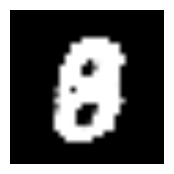

In [96]:
# Load the saved model parameters
model_name = "cvae_jax.pkl"
with open(model_name, "rb") as f:
    params = pickle.load(f)

# Generate a random sample from the latent space
key = jax.random.PRNGKey(0) # change the random key to generate different image
sample = jax.random.normal(key, (1, latent_size))  # Shape (1, latent_size)

# Define the label to condition on
i = 8
i_array = jnp.array([i])  # Wrap `i` in an array
i_onehot = onehot(i_array, condition_size)  # Use the `onehot` function

# Generate the output with the decode method
gen_image = model.apply(params, sample, i_onehot, method=model.decode).reshape(28, 28)

# Visualize the generated image
plt.imshow(gen_image, cmap='gray', interpolation='bilinear')
plt.gcf().set_size_inches(2, 2)  # Adjust display size
plt.axis('off')
plt.show()